# GNN GAT Explainer

The goal of this notebook is to walk through Graph Attention Network (GATs) flavor of a graph neural network (GNN). GATs operate on graphs where nodes are entities  and edges encode relations. Like other attention based networks (e.g. GPT), GATS use attention layers to learn the importance of different relationships A standard GAT layer builds 3 attention layers: 1 for for the features, and 2 for each direction of connection for a node (out, back). The standard GAT typically does not use the graph's adjacency matrix (node neighbor map) and rather uses attention + masking to learn it. There are variants that take add in attention based on the adjacency to make it easier to learn.  A GAT stacks attention layers with ELU normalizations, requiring as many layers as hops that the model is trying to learn. Because GATs learn their networks they are preferable when neighbor quality is uneven or noisy and you want the model to learn which neighbors to trust instead of averaging them uniformly, like a GCn. They’re also better when relationships are asymmetric or context-dependent, since attention can weight edges differently in each direction and based on node features. Also, GATs offer more interpretable edge-level importance scores, which is valuable in domains like biology where explaining which genes or interactions drove a prediction matters. In this notebook we'll show both a traditional GAT layer and a signed GAT layer. to show how they adapt differently 

To help display how GATs work, we'll use a representation of a gene regulatory network where we have 2 specific cell types, a set of genes that are up/down regulated, and then a label for each sample to flag if it's cancerous or not. With our GAT, the goal will be to train it to take in a set of genes and how they're regulated and then predict the cell type as the *node task*, or node level prediction and whether it's cancerous as the *graph task* or graph level prediction. This dual goal will require us to balance 2 loss functions. 

## Graph Data Prep

We'll start with a common preprocessing step. Instead of a typical tokenizer, we have to create a numerical representation of our graph by enumerating the nodes and edges. This process first starts by creating a series of "token-like" IDS for our node vocabulary. In our example that becomes the gene and cell types.  We then use integers to map the relationship of the gene and cell types. This is where our **signed graph** starts since we use `+1` edges for up-regulation and `-1` for down-regulation.   As a result we end up with the following generated:
1. **x_tokens** - a list of nodes
2. **y_node** - per-node (gene) gene cell type labels. This uses a balance of the up-regulated and down-regulated genes and flags for each sample if the gene is more common with B-cells or T-cells.  We use a `-1` here to flag cells to ignore
3. **y_graph** - per-graph (sample) cancer type label. We use `1` for cancerous and `0` for benign
4. **a_list** - the nodes in our graph that link the different cell types and genes together.  We pool all the samples together into a large block-diagonal matrix.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
benign = {
    'Tcells':{'up': ['CD3D','LCK','ZAP70'],'down': ['CD19']},
    'Bcells':{'up': ['CD19','LCK'],'down': ['CD3D','ZAP70']},
  #  'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous = {
     'Tcells':{'up': ['ZAP70'],'down': ['CD19','CD3D','LCK']},
     'Bcells':{'up': ['CD19','CD3D'],'down': ['ZAP70','LCK']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

# cancerous_2 = {
#    'Tcells':{'up': ['CD3D','ZAP70'],'down': ['CD19','LCK']},
#    'Bcells':{'up': ['CD19','LCK','CD3D'],'down': ['ZAP70']},
#    # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
# }

# cancerous_3 = {
#     'Tcells':{'up': ['LCK'],'down': ['ZAP70','CD19','CD3D']},
#     'Bcells':{'up': ['CD19','ZAP70'],'down': ['LCK','CD3D']},
#    # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
# }
graphs = [benign, cancerous] #, cancerous_2, cancerous_3]

In [3]:
cell_types = ['Tcells','Bcells']
genes = ['CD3D','LCK','ZAP70','CD19'] #only focused on genes present
node_order = genes + [f'CT_{ct}' for ct in cell_types]   # genes first, then CT nodes
gene_mask = torch.tensor([1,1,1,1,0,0], dtype=torch.bool)
N = len(node_order) 

In [4]:
def build_vocab(genes, cell_types):
    toks = genes + [f'CT_{ct}' for ct in cell_types]
    stoi = {t:i for i,t in enumerate(toks)}; itos = {i:t for t,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(genes, cell_types)
vocab_size = len(stoi)

vocab_size, stoi

(6,
 {'CD3D': 0, 'LCK': 1, 'ZAP70': 2, 'CD19': 3, 'CT_Tcells': 4, 'CT_Bcells': 5})

In [5]:
def make_graph_signed(spec):
    N = len(node_order); 
    A_signed = torch.zeros(N, N)
    def idx(n): 
        return node_order.index(n)
    def add_edge(g, ct, s):
        i, j = idx(g), idx(f"CT_{ct}")
        A_signed[i,j] = s
        A_signed[j,i] = s
    for ct in cell_types:
        for g in spec[ct].get('up', []):   
            add_edge(g, ct, +1)
        for g in spec[ct].get('down', []): 
            add_edge(g, ct, -1)
    # labels for node task (0=T, 1=B) on genes only
    y_node = torch.full((N,), -1, dtype=torch.long)
    X = torch.tensor([stoi[n] for n in node_order], dtype=torch.long)
    
    # per-gene cell-type label: 0=Tcells, 1=Bcells (prefer UP, tie-break T→B, fallback from DOWN)
    y_node = torch.full((N,), -1, dtype=torch.long)
    for g in genes:
        t_up = g in spec['Tcells'].get('up', [])
        b_up = g in spec['Bcells'].get('up', [])
        t_dn = g in spec['Tcells'].get('down', [])
        b_dn = g in spec['Bcells'].get('down', [])
        lab = None
        if t_up and not b_up: 
            lab = 0
        elif b_up and not t_up: 
            lab = 1
        elif t_up and b_up: 
            lab = 0
        else:
            if t_dn and not b_dn: 
                lab = 1
            elif b_dn and not t_dn: 
                lab = 0
        if lab is not None: 
            y_node[idx(g)] = lab
    return X, y_node, A_signed

In [6]:
x_list, y_node_list, a_list = [], [], []
for spec in graphs:
    X_i, y_i, A_i = make_graph_signed(spec)
    x_list.append(X_i); y_node_list.append(y_i); a_list.append(A_i)

x_list, y_node_list, a_list

([tensor([0, 1, 2, 3, 4, 5]), tensor([0, 1, 2, 3, 4, 5])],
 [tensor([ 0,  0,  0,  1, -1, -1]), tensor([ 1, -1,  0,  1, -1, -1])],
 [tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1.,  1.,  1., -1.,  0.,  0.],
          [-1.,  1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1., -1.,  1., -1.,  0.,  0.],
          [ 1., -1., -1.,  1.,  0.,  0.]])])

**x_tokens** - a list of nodes

Notice that all nodes are present in each of our samples. 

In [7]:
x_tokens = torch.stack(x_list)
x_tokens.size(), x_tokens

(torch.Size([2, 6]),
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-node (gene) gene cell type labels. This uses a balance of the up-regulated and down-regulated genes and flags for each sample. If the gene is more commonly upregulated with B-cells we flag it as `0` and if it's more commonly up-regulated in T-cells we flag it as `1`.  This evaluation is done per sample (seen here as per row). 

The last two columns are embeddings purely for cell type so we flag them as -1 to be masked during training. 

In [8]:
y_node = torch.stack(y_node_list)
y_node.size(), y_node

(torch.Size([2, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 1, -1,  0,  1, -1, -1]]))

**y_graph** - per-graph (sample) cancer type label. We use `1` for cancerous and `0` for benign

In [9]:
y_graph = torch.tensor([0,1])  # 0=wild, 1=cancer
y_graph.size(), y_graph

(torch.Size([2]), tensor([0, 1]))

**Graph** 

Since this is a GNN explainer, let's visualize actually how these graphs look. This is in essence the graph the model is looking at and learning how to read so that if it sees a new one, it can predict the properties we are minimizing loss on (cancerous, cell type). 

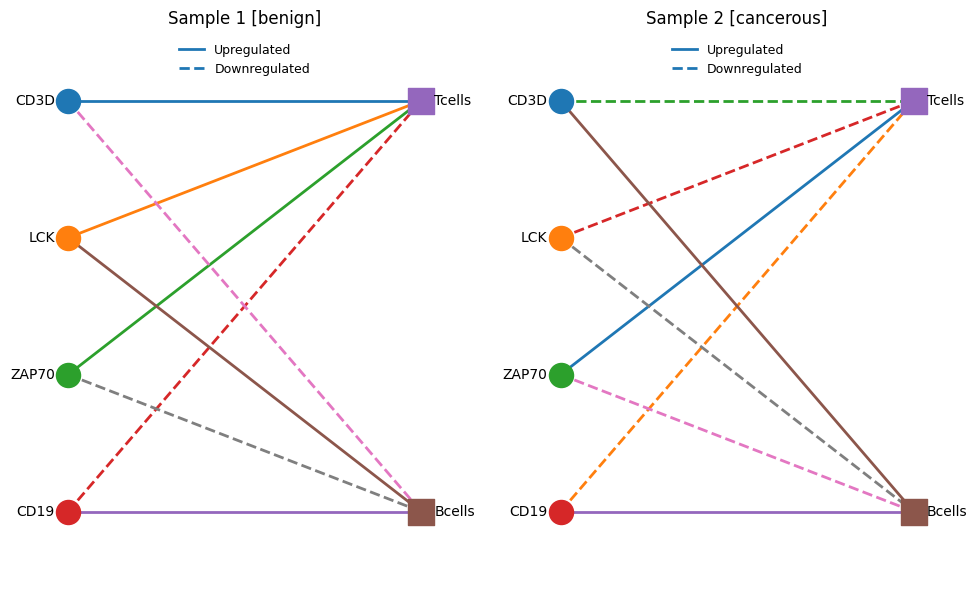

In [10]:
def compute_positions(genes, cell_types):
    # left column (genes), right column (cell types)
    gx, cx = 0.1, 0.9
    gy = list(range(len(genes)-1, -1, -1))  # top-to-bottom
    if len(cell_types) > 1:
        # spread CTs across same vertical span as genes
        span = (len(genes)-1)
        cy = [span * (1 - i/(len(cell_types)-1)) for i in range(len(cell_types))]
    else:
        cy = [(len(genes)-1)/2]
    pos = {g:(gx, gy[i]) for i,g in enumerate(genes)}
    pos.update({f"CT_{ct}":(cx, cy[j]) for j,ct in enumerate(cell_types)})
    return pos

def draw_sample(ax, spec, title, genes, cell_types):
    pos = compute_positions(genes, cell_types)
    # draw nodes
    for i,g in enumerate(genes):
        x,y = pos[g]
        ax.scatter([x],[y], s=300, marker='o', zorder=3)
        ax.text(x-0.03, y, g, va='center', ha='right', fontsize=10)
    for ct in cell_types:
        name = f"CT_{ct}"
        x,y = pos[name]
        ax.scatter([x],[y], s=350, marker='s', zorder=3)
        ax.text(x+0.03, y, ct, va='center', ha='left', fontsize=10)
    # draw edges: solid = upregulated (+1), dashed = downregulated (-1)
    for ct in cell_types:
        ct_name = f"CT_{ct}"
        for g in spec[ct].get('up', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='-', linewidth=2, zorder=2)
        for g in spec[ct].get('down', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='--', linewidth=2, zorder=2)

    # aesthetics
    ax.set_title(title)
    ax.set_xlim(0.0, 1.0)
    ys = list(range(len(genes)))
    ax.set_ylim(-0.5, len(genes)-0.5)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)

    # legend (solid=up, dashed=down)
    from matplotlib.lines import Line2D
    legend_lines = [
        Line2D([0],[0], linestyle='-', linewidth=2, label='Upregulated'),
        Line2D([0],[0], linestyle='--', linewidth=2, label='Downregulated'),
    ]
    ax.legend(handles=legend_lines, loc='upper center', frameon=False, fontsize=9)

# ----- draw all four samples -----
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
samples = [
    ('Sample 1 [benign]',    benign),
    ('Sample 2 [cancerous]',    cancerous),
    #('Sample 3 [cancerous]',  cancerous_2),
    #('Sample 4 [cancerous]',  cancerous_3),
]
for ax, (name, spec) in zip(axes.ravel(), samples):
    draw_sample(ax, spec, name, genes, cell_types)

plt.tight_layout()
plt.show()

# Modeling

A machine learning model forward pass now uses the data prep information, runs several layers of linear algebra on it, and then "predicts" the probability of our different tasks, in this case the cell type based on the node and whether a graph is cancerous. When it is noisy (like you will see in this example), this process results in gibberish.  The training process changes the noise to pattern during the "backward pass" as you'll see. We'll show 3 steps that are focused on training:
1. **Data Loading** - this step pulls from the raw data enough examples and batches to complete a forward pass and loss calculation.  If the model is inference only, this step is replaced with taking in the inference input and preparing it similarly as the forward pass. 
2. **Forward Pass** - using the data and the model architecture we run a prediction for the tokens. When training we also compare against the expected to get loss, but in inference, we use the logits to complete the inference task.
3. **Back Propagation, aka Backward Pass & Training** - using differentials we can understand what parameters most drive the difference between forward pass' impact on its prediction versus what is actually right based on the data loading step. We compare this based on the loss function and use the partial derivative gradients to make very minor adjustments to the impactful parameters with the hope it improves future predictions.

After our back prop, we'll show a final **Forward Pass** with the updated weights we did in #3 and then convert those final weights to a **Model Inference**

## Data Loading

To start, we need to get enough data to run the forward and backward passes.  Since our total dataset in a real experiment is likely too big to be held in memory all at once in real practice, we will read just enough file information into memory so that we can run the passes, leaving memory and compute to be used on the passes instead of static data holding. 
To start, we have to identify the batch size and the model context length to determine how much data we need.  Consequently, these dimensions also form 2 of the 3 dimensions in the initial matrix.
- **Batch Size (B)** - This is the number of examples you'll train on in a single pass. 
- **Number of Nodes (N)** - This is basically the "context length" for a GNN.  This is the max number of nodes that a model can use in a pass.

Beyond these, in a GCN, the depth also controls how much context, or complexity, can be learned. This is because each GCN layer learns 1 hop, or 1 relationship of neighbors. This means that after $L$ layers, a model can learn $L$-hops worth of context.

In our case we'll set our batch to be our 4 examples, and nodes to the nodes we have configured, 6. As we walk through you'll also see our GCN will have 2 layers to model 2 network hops: gene > cell type > other genes.

We'll prepare 2 sets of data. Our **Inputs** will be the `x_token`, or our list of nodes for each example, and `a_list`, our list of node connections.  Our **Outputs** will be `y_node`, our node level cell type identification, and `y_graph`, the graph level cancerous identification. 

**x_tokens** — list of nodes for each example. Each entry is an integer token id for the node at that position in node_order (e.g.`['CD3D','LCK','ZAP70','CD19','CT_Tcells','CT_Bcells']`).  In our case you'll notice that each example contains all the nodes. 

In [11]:
B_batch, N_nodes = x_tokens.shape
B_batch, N_nodes, x_tokens

(2,
 6,
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-gene label for cell-type. `0` for T-cell marker and tie, `1` for B-cell marker. As a reminder, this is an aggregation of the up-regulated and down-regulated genes. We focus on which cell type has the gene up-regulated and, if both have it, we use 0. There are ways to handle ties better but we won't get into it.  Since `y_node` also includes the cell types, we'll use -1 to mask them as ignored.

In [12]:
y_node.size(), y_node

(torch.Size([2, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 1, -1,  0,  1, -1, -1]]))

**y_graph** - per-graph label to determine if an example is cancerous. `0` is for benign and `1` is for cancerous.  

In [13]:
y_graph.size(), y_graph

(torch.Size([2]), tensor([0, 1]))

**A_list** - The relationships for each of our cells.  You'll notice here that only the last two rows and columns are used.  In this tensor `+1` is for **upregulated** gene per cell type and `-1` is for **downregulated**. `0` is for not in the network.  We also include here a **Gene_mask** that will act in our loss function as a flag to suppress the gene x gene portions of the matrix. 

In [14]:
gene_mask, a_list

(tensor([ True,  True,  True,  True, False, False]),
 [tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1.,  1.,  1., -1.,  0.,  0.],
          [-1.,  1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1., -1.,  1., -1.,  0.,  0.],
          [ 1., -1., -1.,  1.,  0.,  0.]])])

### Data Loading - Blocked Diagonal Graph

Since we are trying to learn from all the examples in our batch, we want a uniform tensor of the network connections to learn from. We do this using a block diagonal join that creates a large tensor out of the inputs by simply sliding each new tensor to start at `[i+1,j+1]`.  In our case this results in a `[121224]` matrix since we have 2 examples with 6 nodes. 

In [15]:
a_blk = torch.block_diag(*a_list)
a_blk.size(), a_blk

(torch.Size([12, 12]),
 tensor([[ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1.,  1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  1.,  0.,  0.]]))

## Forward pass

<img src="explainer_screenshots/gat/full_network.png" width="300">

During training, in the GAT we've built, the forward pass takes in the set of nodes per example and a signed network map and uses this to predict the cell type by node and the cancerous level of the graph. This can be viewed as two different classification task at the head level where the head is different for each task. Here the "batch" and "token" dimensions are one in the same, being that we just have 1 dimension to signify our examples, which we'll call batch.  We could layer in batch based learning but it would make this notebook too complicated and lengthy. 

Our walkthrough of the forward pass is focused on training where we'll pass in the input nodes `x_tokens` and signed graph `a_blk`, carry that input through the layers, and generate 2 matrices of the probability for the node and graph level prediction. These predictions will be two different sets of `logits`. During the forward pass, after embedding our input nodes we'll pass through two different GAT layers to show how a signed layer and a typical layer behave and to allow the model to learn from 2 hops instead of just 1. 

At the end of the forward pass we then compare the probability in the logits to the actual next token in `y_node, y_graph` and calculate `loss` based on the difference. You'll see that we calculate the loss on each head, then sum it for a final loss (and so that we can distribute across both pathways in backprop). This difference is what we'll then use in the backprop/training steps.  

*Note that we will do some layer initialization to simplify following along.  In reality, layers are often initialized to normal distribution with some adjustments made for parameter sizes, called Xaviar Uniform, to keep the weights properly noisy.  Xaviar Uniform distributes close to 0 and  is designed so that variance of activations and gradients is preserved across layers for linear / tanh / sigmoid-style networks.  We will not cover initialization in this series*

**Attention Heads**

The beauty with attention is the use of multiple heads to allow for learning of different complext concepts.  The more complex concepts you think you want to learn, the more heads you will want to include.  This scaling allows for a broader generalization during training and usage.  

Note that the embedding channels need to be cleanly divisible into the heads to allow for flow-through. This is different than in a GPT where each attention head has the same number of channels as the embedding layer.  We're mainly doing it differently to show that both structures work, to make gradient flow easier to aid in explainability, and to reduce the footprint used. 

In [16]:
n_embd= 6
heads = 2
head_dim = n_embd // heads
depth = 1 # just a single hop
head_dim

3

### Embedding Projection

<img src="explainer_screenshots/gat/input_layer.png" width="400">

We'll first create an initial **embedding layer** for our sample level node tokens. Recall that this is the layer that will add the second dimension to our node list. We start with supplying only the nodes. In parallel our adjacency graphs will also be kept on the side as they'll be inputs to the next layer. Generally, by using an embedding on the node, we give the graph a chance to learn how important the different nodes are per example and how to use them, and the node order, in our output prediction task.  We'll also use a small embedding dimension to allow the network to learn a deeper representation of our nodes. After doing the embedding, we'll then remove our batch dimensions for the remaining training to simplify our training.  

We'll start by initializing the weight to a sliding scale so that we can quickly see each layer's impact. 

In [17]:
tok_emb = nn.Embedding(vocab_size, n_embd)
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = vocab_size, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.001*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    tok_emb.weight.copy_(pattern)
tok_emb.weight.size(), tok_emb.weight

(torch.Size([6, 6]),
 Parameter containing:
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]], requires_grad=True))

**Embedding projection**

Remember that each of our samples includes all the nodes so we expect that all the weights will be used repeatedly for each sample.  

In [18]:
x = tok_emb(x_tokens)
x.size(), x

(torch.Size([2, 6, 6]),
 tensor([[[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
          [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
 
         [[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
          [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]]],
        grad_fn=<EmbeddingBackward0>))

**Remove batch**

Now we'll remove the batch for further training and learning. If you recall we combined our networks using blocked diagonal so the batch removal now aligns the "sample"/"node" dimension  with the dimension in the network tensor. 

In [19]:
x = x.view(B_batch*N_nodes,n_embd) # remove batch
x.size(), x

(torch.Size([12, 6]),
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110],
         [0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
        grad_fn=<ViewBackward0>))

### GAT Block

<img src="explainer_screenshots/gat/block_details.png" width="400">

To support our two hops of learning (Cell type > gene > cell type) we stack two signed graph attention layers with a nonlinearity to learn increasingly expressive node features. We have two different types of attention layers: one that includes the signed graph attention and one closer to a vanilla GAT that only has attention on the nodes. 


Each graph attention layer first projects node embeddings with a shared linear map per head, then computes edge-wise attention scores that depend on both endpoint features and, if signed, the sign of the interaction. For each head $h$, we form
$$
e_{ij}^{h}=\text{LeakyReLU}\big((a_{src}^{h})^\top W^{h}x_i + (a_{dst}^{h})^\top W^{h}x_j\big),
$$
If the GAT is signed an addition $a_{sign}^{h} s_{ij}$ is added. 

After this, we mask non-edges, and apply a softmax over neighbors $j$ to get attention weights $\alpha_{ij}^{h}$. The updated node state is then a signed, attention-weighted aggregation of neighbor “values”

$$
h_i^{\prime(h)}=\sum_j \alpha_{ij}^{h} W^{h}x_j
$$

If the GAT is signed, we also multiply by our signed edges $s_{ij}$ again. We concatenate the multi-head outputs back into a single embedding.  In this structure, the attention Query, Key, and Value can be thought of as
* $Query = (a_{src}^{h})^\top W^{h}x_i$
* $Key = (a_{dst}^{h})^\top W^{h}x_j$
* $Value = W^{h}x_j$

We apply dropout to node features and attention coefficients to regularize both representations and neighbor selection. We use an LeakyReLU nonlinearity inside each GAT and ELU between GAT to preserve informative negative signals, and add residual connections around stacked attention layers so information can bypass noisy edges, allowing deeper models that remain expressive while still respecting up vs. down regulation patterns encoded by the signed edges.

#### GAT Block - Signed First Attention Layer

<img src="explainer_screenshots/gat/signed_gat.png" width="400">

Our first GAT layer is signed so it included the attention for the signed network to the standard GAT structure. This means that we perform the following:
$$
e_{ij}^{h}=\text{LeakyReLU}\big((a_{src}^{h})^\top W^{h}x_i + (a_{dst}^{h})^\top W^{h}x_j + a_{sign}^{h} \odot s_{ij}\big),
$$

The addition of the signed edge attention allows the model to use the known graph edges without having to learn them in the attention alone. This allows the model to learn with less data.  

For this GAT layer, we'll 
1. Run feature dropout
2. Calculate our linear projection and node attention
3. Calculate the signed edge attention
4. Run nonlinearity, masking, and softmax
5. Calculate the Hadamard product of the attention and the signed network map.
6. Take the dot product of the edge attention with the linear projection creating a learned network map.
7. A final ELU nonlinearity to support positive and negative values. 

The inclusion of the Hadamard product allows for gradients to flow down to individual elements of the network map allowing for more precise learning. 

##### Feature Dropout

We'll start with Feature level dropout in the incoming embedding.  Dropout will randomly zero out any value effectively removing that specific node from impacting prediction. Since this is Bernoulli based dropout, in addition to zeroing out weights the surviving entries are scaled by $1/(1-p)$.  Feature level dropout stops the model from overfitting to very specific feature patterns and encourages robustness in the learned representations before attention even happens. You can think of it as applying the following: “don’t over-trust any single feature dimension.” 

Since this introduces `0` you can quickly see the dropout's impact on the embeddings.  You'll also see a 10% increase in the value of each row due to the normalizaiton that dropout does. 

In [20]:
feat_dropout=0.10
gat1_fdrop = nn.Dropout(feat_dropout)

In [21]:
x_drop = gat1_fdrop(x)
x_drop.size(), x_drop

(torch.Size([12, 6]),
 tensor([[0.0011, 0.0022, 0.0033, 0.0000, 0.0056, 0.0000],
         [0.0022, 0.0033, 0.0044, 0.0056, 0.0067, 0.0078],
         [0.0033, 0.0044, 0.0056, 0.0067, 0.0078, 0.0089],
         [0.0044, 0.0056, 0.0067, 0.0078, 0.0089, 0.0100],
         [0.0056, 0.0067, 0.0078, 0.0089, 0.0100, 0.0111],
         [0.0067, 0.0000, 0.0089, 0.0000, 0.0111, 0.0000],
         [0.0011, 0.0022, 0.0033, 0.0044, 0.0056, 0.0067],
         [0.0022, 0.0033, 0.0044, 0.0056, 0.0067, 0.0078],
         [0.0033, 0.0044, 0.0056, 0.0067, 0.0078, 0.0000],
         [0.0044, 0.0056, 0.0067, 0.0000, 0.0089, 0.0100],
         [0.0056, 0.0067, 0.0078, 0.0089, 0.0100, 0.0111],
         [0.0067, 0.0000, 0.0089, 0.0100, 0.0111, 0.0000]],
        grad_fn=<MulBackward0>))

##### Per-Head linear projection
Our first step is to a multi-headed linear projection of the node features.  We create a separate weighted matrix per head so that each head can learn concepts indepndently.  This slices the embedding space into learned sub-spaces for attention to interact with. This subspace is at the node level allowing the attention to interact with different weights of each node when building connections. 

We'll initilize both heads at the same sliding weight. Because of this you'll see the two heads result in the same product and each channel scales the previous one.

In [22]:
gat1_attn_w = nn.Parameter(torch.empty(heads, n_embd, head_dim))
with torch.no_grad(): 
    vs, d = n_embd, head_dim
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.1*(1 + cols)  # W[i,j] = 0.001*(1+i+j)
    gat1_attn_w.copy_(pattern)
gat1_attn_w.size(), gat1_attn_w

(torch.Size([2, 6, 3]),
 Parameter containing:
 tensor([[[0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000]],
 
         [[0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000]]], requires_grad=True))

In [23]:
Hproj = x_drop @ gat1_attn_w
Hproj.size(), Hproj

(torch.Size([2, 12, 3]),
 tensor([[[0.0012, 0.0024, 0.0037],
          [0.0030, 0.0060, 0.0090],
          [0.0037, 0.0073, 0.0110],
          [0.0043, 0.0087, 0.0130],
          [0.0050, 0.0100, 0.0150],
          [0.0027, 0.0053, 0.0080],
          [0.0023, 0.0047, 0.0070],
          [0.0030, 0.0060, 0.0090],
          [0.0028, 0.0056, 0.0083],
          [0.0036, 0.0071, 0.0107],
          [0.0050, 0.0100, 0.0150],
          [0.0037, 0.0073, 0.0110]],
 
         [[0.0012, 0.0024, 0.0037],
          [0.0030, 0.0060, 0.0090],
          [0.0037, 0.0073, 0.0110],
          [0.0043, 0.0087, 0.0130],
          [0.0050, 0.0100, 0.0150],
          [0.0027, 0.0053, 0.0080],
          [0.0023, 0.0047, 0.0070],
          [0.0030, 0.0060, 0.0090],
          [0.0028, 0.0056, 0.0083],
          [0.0036, 0.0071, 0.0107],
          [0.0050, 0.0100, 0.0150],
          [0.0037, 0.0073, 0.0110]]], grad_fn=<CloneBackward0>))

#####  Linear Node Attention

Our linear Node attention now takes the per-head project and starts creating edge-specific weigths between each pair of connected nodes. This is where our GAT layer begins to learn the adjacency importance. We still skeep separation by head so that each head can learn it's own relationships. For each head, it scores a builds potential edges edge $i \leftarrow j$ by applying a learned vector to the destination features (thought of as a key) and another to the source features (thought of as a value), then adding them to get a compatibility logit $e_{ij}^{h}$. These learned weights represent “how much should node $i$ listen to node $j$ for this head.” This makes neighbor influence data-driven and asymmetric: different heads can specialize to different patterns (e.g. strong T-cell–like signatures, aberrant cancer patterns), and each node can selectively amplify or suppress specific neighbors rather than averaging them uniformly.

**Source node (query)**

We'll start with the source first. We'll initialize the heads so that the second head is double the first.  As a result you can see that the output of this shows the second head as double the first. We will also initilize with consisten weights across the head dimension so that that we can see in backprop how the model changes the importance of the different dimensions thereby building a network representation.

In [24]:
gat1_attn_src = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    src_pattern = torch.tensor([[[0.1],[0.1],[0.1]],[[0.2],[0.2],[0.2]]])
    gat1_attn_src.copy_(src_pattern)
gat1_attn_src.size(), gat1_attn_src

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.1000],
          [0.1000],
          [0.1000]],
 
         [[0.2000],
          [0.2000],
          [0.2000]]], requires_grad=True))

In [25]:
e_src = Hproj @ gat1_attn_src
e_src.size(), e_src

(torch.Size([2, 12, 1]),
 tensor([[[0.0007],
          [0.0018],
          [0.0022],
          [0.0026],
          [0.0030],
          [0.0016],
          [0.0014],
          [0.0018],
          [0.0017],
          [0.0021],
          [0.0030],
          [0.0022]],
 
         [[0.0015],
          [0.0036],
          [0.0044],
          [0.0052],
          [0.0060],
          [0.0032],
          [0.0028],
          [0.0036],
          [0.0033],
          [0.0043],
          [0.0060],
          [0.0044]]], grad_fn=<UnsafeViewBackward0>))

In [26]:
e_src = e_src.permute(1, 2, 0)
e_src.size(), e_src

(torch.Size([12, 1, 2]),
 tensor([[[0.0007, 0.0015]],
 
         [[0.0018, 0.0036]],
 
         [[0.0022, 0.0044]],
 
         [[0.0026, 0.0052]],
 
         [[0.0030, 0.0060]],
 
         [[0.0016, 0.0032]],
 
         [[0.0014, 0.0028]],
 
         [[0.0018, 0.0036]],
 
         [[0.0017, 0.0033]],
 
         [[0.0021, 0.0043]],
 
         [[0.0030, 0.0060]],
 
         [[0.0022, 0.0044]]], grad_fn=<PermuteBackward0>))

**Destination (key)**
Next we'll build the destination attention. We'll initialize the heads so that the first head is 1.5x the second and that both heads are negative.  As a result you can see the ratio is maintained for the destination and you'll see that we get negative weights, signaling in our case downregulation being important. We are doing this to help show that both positive and negative weights are useful. 

In [29]:
gat1_attn_dst = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    dst_pattern = torch.tensor([[[-0.3],[-0.3],[-0.3]],[[-0.2],[-0.2],[-0.2]]])
    gat1_attn_dst.copy_(dst_pattern)
gat1_attn_dst.size(), gat1_attn_dst

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[-0.3000],
          [-0.3000],
          [-0.3000]],
 
         [[-0.2000],
          [-0.2000],
          [-0.2000]]], requires_grad=True))

In [30]:
e_dst = Hproj @ gat1_attn_dst
e_dst.size(), e_dst

(torch.Size([2, 12, 1]),
 tensor([[[-0.0022],
          [-0.0054],
          [-0.0066],
          [-0.0078],
          [-0.0090],
          [-0.0048],
          [-0.0042],
          [-0.0054],
          [-0.0050],
          [-0.0064],
          [-0.0090],
          [-0.0066]],
 
         [[-0.0015],
          [-0.0036],
          [-0.0044],
          [-0.0052],
          [-0.0060],
          [-0.0032],
          [-0.0028],
          [-0.0036],
          [-0.0033],
          [-0.0043],
          [-0.0060],
          [-0.0044]]], grad_fn=<UnsafeViewBackward0>))

In [31]:
e_dst = e_dst.permute(2, 1, 0)
e_dst.size(), e_dst

(torch.Size([1, 12, 2]),
 tensor([[[-0.0022, -0.0015],
          [-0.0054, -0.0036],
          [-0.0066, -0.0044],
          [-0.0078, -0.0052],
          [-0.0090, -0.0060],
          [-0.0048, -0.0032],
          [-0.0042, -0.0028],
          [-0.0054, -0.0036],
          [-0.0050, -0.0033],
          [-0.0064, -0.0043],
          [-0.0090, -0.0060],
          [-0.0066, -0.0044]]], grad_fn=<PermuteBackward0>))

**Combine Node Directions Together**

Now we'll need to combine our two attention weights together.  This combination creates `[12,12]` weights creating the dimension necessary to learn the network that we have encoded in `a_blk`.  You'll see that this matches up with the dimensions of our adjacency map which is a nice mapping and shows what these weights are attempting to learn.  

Because we used a negative destination, with scalers bigger than the source, you'll see that in most cases the values are negative.  This just means that at this current initiation state the model thinks down-regulation is very important. Also, because of how our input `x_token` and embeddings have been initiated, you'll see that we actually have a repetition of two equal `[6,12,2]`.  As we do backprop and learning, this should adjust. 

In [33]:
e = e_src + e_dst
e.size(), e

(torch.Size([12, 12, 2]),
 tensor([[[-1.4667e-03,  0.0000e+00],
          [-4.6667e-03, -2.1333e-03],
          [-5.8667e-03, -2.9333e-03],
          [-7.0667e-03, -3.7333e-03],
          [-8.2667e-03, -4.5333e-03],
          [-4.0667e-03, -1.7333e-03],
          [-3.4667e-03, -1.3333e-03],
          [-4.6667e-03, -2.1333e-03],
          [-4.2667e-03, -1.8667e-03],
          [-5.6667e-03, -2.8000e-03],
          [-8.2667e-03, -4.5333e-03],
          [-5.8667e-03, -2.9333e-03]],
 
         [[-4.0000e-04,  2.1333e-03],
          [-3.6000e-03,  0.0000e+00],
          [-4.8000e-03, -8.0000e-04],
          [-6.0000e-03, -1.6000e-03],
          [-7.2000e-03, -2.4000e-03],
          [-3.0000e-03,  4.0000e-04],
          [-2.4000e-03,  8.0000e-04],
          [-3.6000e-03,  0.0000e+00],
          [-3.2000e-03,  2.6667e-04],
          [-4.6000e-03, -6.6667e-04],
          [-7.2000e-03, -2.4000e-03],
          [-4.8000e-03, -8.0000e-04]],
 
         [[-2.3283e-10,  2.9333e-03],
          [-3.2000

##### Signed Edge Attention

This version of our GAT includes learned attention for the signed edges.  This is non-standard for GAT but I wanted to show how you'd inject it into the Attention block.  Since we want this to be an influence on the learned network attention, we need to learn how much an edge should influence. We achieve this by using a learned scaler and the Hadamard product, or element wise product. This allows each value to be multiplied by a learned scalar.  Additionally, since we have multi-headed attention, we will need two scalares so that each head can learn independently. 

We'll start by first prepping our adjacency map.  We'll need to do 3 things:
1. We want to make sure that our adjacency allows nodes to learn self references, so we first want to fill in the diagonal with a non-0 value.  We'll use `0.5` since `1` is upregulated and `-1` is downregulated. 
2. Since we have the adjacency and are going to manipulate it, we first will extract the adjacency mask out.  This mask will be used on our network attention to break the back-propogation on node interactions that are not present in our example.  We'll cover how that's done in the masking step.
3. Extract the edges out of the adjacency and multiply them by the scalar. This will be our learned Signed Edge Attention where the model can decide how much of the edge is important to the network. 

**Prep Adjacency Map**

We'll first start by filling the diagnoal and extracting a mask.  The mask will be a boolean tensor that shows all of the entries in our adjacency that are not connected.  

In [34]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(0.5)                       # self-loops are positive
mask = (signed_a == 0)  
mask.size(), mask

(torch.Size([12, 12]),
 tensor([[False,  True,  True,  True, False, False,  True,  True,  True,  True,
           True,  True],
         [ True, False,  True,  True, False, False,  True,  True,  True,  True,
           True,  True],
         [ True,  True, False,  True, False, False,  True,  True,  True,  True,
           True,  True],
         [ True,  True,  True, False, False, False,  True,  True,  True,  True,
           True,  True],
         [False, False, False, False, False,  True,  True,  True,  True,  True,
           True,  True],
         [False, False, False, False,  True, False,  True,  True,  True,  True,
           True,  True],
         [ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
          False, False],
         [ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
          False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
          False, False],
         [ True,  True,  True,  

In [35]:
signed_a = signed_a.unsqueeze(-1) # [M,M,1] sign tensor
signed_a.size(), signed_a

(torch.Size([12, 12, 1]),
 tensor([[[ 0.5000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 1.0000],
          [-1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.5000],
          [ 0.0000],
          [ 0.0000],
          [ 1.0000],
          [ 1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.0000],
          [ 0.5000],
          [ 0.0000],
          [ 1.0000],
          [-1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.5000],
          [-1.0000],
          [ 1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],

**Edge Attention**

Now we'll calcualte our edge attention. We'll initiate our first head to be 2x our second.  Also, because our adjacency map is simply either `[-1,0.5,1]` when it's not 0, you can see how the edge gets projected to the two heads.  

In [36]:
gat1_attn_sign = nn.Parameter(torch.zeros(1, 1, heads))
with torch.no_grad(): 
    sign_pattern = torch.tensor([[[0.2, 0.1]]])
    gat1_attn_sign.copy_(sign_pattern)
gat1_attn_sign.size(), gat1_attn_sign

(torch.Size([1, 1, 2]),
 Parameter containing:
 tensor([[[0.2000, 0.1000]]], requires_grad=True))

In [37]:
e_sig_a = signed_a * gat1_attn_sign
e_sig_a.size(), e_sig_a

(torch.Size([12, 12, 2]),
 tensor([[[ 0.1000,  0.0500],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.2000,  0.1000],
          [-0.2000, -0.1000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.1000,  0.0500],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.2000,  0.1000],
          [ 0.2000,  0.1000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.1000,  0.0500],
          [ 0.0000,  0.0000],
          [ 0.2000,  0.1000],
          [-0.2000, -0.1000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
        

**Combine Node and Edge Attention**
Now to allow our Edge attention to have an impact on the learned node attention, we need to combine them.  This is a simple summation of the two weights. You'll see that in some of the edges the values were pulled positive showing how impactful the signed edge attention can be when included.   

In [39]:
out = e + e_sig_a 
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[ 9.8533e-02,  5.0000e-02],
          [-4.6667e-03, -2.1333e-03],
          [-5.8667e-03, -2.9333e-03],
          [-7.0667e-03, -3.7333e-03],
          [ 1.9173e-01,  9.5467e-02],
          [-2.0407e-01, -1.0173e-01],
          [-3.4667e-03, -1.3333e-03],
          [-4.6667e-03, -2.1333e-03],
          [-4.2667e-03, -1.8667e-03],
          [-5.6667e-03, -2.8000e-03],
          [-8.2667e-03, -4.5333e-03],
          [-5.8667e-03, -2.9333e-03]],
 
         [[-4.0000e-04,  2.1333e-03],
          [ 9.6400e-02,  5.0000e-02],
          [-4.8000e-03, -8.0000e-04],
          [-6.0000e-03, -1.6000e-03],
          [ 1.9280e-01,  9.7600e-02],
          [ 1.9700e-01,  1.0040e-01],
          [-2.4000e-03,  8.0000e-04],
          [-3.6000e-03,  0.0000e+00],
          [-3.2000e-03,  2.6667e-04],
          [-4.6000e-03, -6.6667e-04],
          [-7.2000e-03, -2.4000e-03],
          [-4.8000e-03, -8.0000e-04]],
 
         [[-2.3283e-10,  2.9333e-03],
          [-3.2000

##### Leaky ReLU

Next we apply leaky ReLU (rectified linear units), an element-wise nonlinearity that leaves positive activations unchanged and scales negative activations by a small factor, in our case `0.5`. In graph networks it is commonly used to introduce nonlinearity while preserving gradient flow through negative values and avoiding “dying units.” Additionally, leaky ReLU preserves relative ordering between moderately negative vs strongly negative scores, which still matters once you apply the softmax across neighbors. In our signed setup, it’s especially useful because negative contributions (e.g. down-regulation) don’t get hard-clipped; they remain part of the competition for attention instead of being erased outright like would be the case if using ReLU.

The formula applied is:
$$
y=\max(\alpha x,x)=
\begin{cases}
x,& x>0\\
\alpha x,& x\leq 0
\end{cases} \quad
\frac{\partial y}{\partial x}=
\begin{cases}
1,& x>0 \\
\alpha,& x\leq 0
\end{cases}
$$

LeakyReLU is stateless, meaning it has no learnable parameters.  As an output you can see that positive values remained in their state while negative values were cut in half. 

In [40]:
gat1_attn_lrelu = nn.LeakyReLU(0.5, inplace=True)
out = gat1_attn_lrelu(out)
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[ 9.8533e-02,  5.0000e-02],
          [-2.3333e-03, -1.0667e-03],
          [-2.9333e-03, -1.4667e-03],
          [-3.5333e-03, -1.8667e-03],
          [ 1.9173e-01,  9.5467e-02],
          [-1.0203e-01, -5.0867e-02],
          [-1.7333e-03, -6.6667e-04],
          [-2.3333e-03, -1.0667e-03],
          [-2.1333e-03, -9.3333e-04],
          [-2.8333e-03, -1.4000e-03],
          [-4.1333e-03, -2.2667e-03],
          [-2.9333e-03, -1.4667e-03]],
 
         [[-2.0000e-04,  2.1333e-03],
          [ 9.6400e-02,  5.0000e-02],
          [-2.4000e-03, -4.0000e-04],
          [-3.0000e-03, -8.0000e-04],
          [ 1.9280e-01,  9.7600e-02],
          [ 1.9700e-01,  1.0040e-01],
          [-1.2000e-03,  8.0000e-04],
          [-1.8000e-03,  0.0000e+00],
          [-1.6000e-03,  2.6667e-04],
          [-2.3000e-03, -3.3333e-04],
          [-3.6000e-03, -1.2000e-03],
          [-2.4000e-03, -4.0000e-04]],
 
         [[-1.1642e-10,  2.9333e-03],
          [-1.6000

##### Masking
Our next step is to mask the edges that we know are not present in our example.  Recall that we built the boolean based mask from our adjacency map when building the signed edge attention. In this mask, a `true` value represented a connection that needed to be suppressed. 

Since this is the branch for node connections , we need to mute the weights for where there is no edge so that gradients can't flow backwards there. We'll do this in 2 steps.  First we'll replace the values with $-\infty$ and then during `softmax` those values will become 0. 

Similar to other steps, we'll need to unrabel our mask to a representation of each edge and then our masked fill will apply the value across both heads. You'll see that after masking the weight sparcity significantly jumps. 

In [42]:
out = out.masked_fill(mask.unsqueeze(-1), float('-inf'))
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[ 0.0985,  0.0500],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.1917,  0.0955],
          [-0.1020, -0.0509],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [ 0.0964,  0.0500],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.1928,  0.0976],
          [ 0.1970,  0.1004],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.0956,  0.0500],
          [   -inf,    -inf],
          [ 0.1932,  0.0984],
          [-0.1013, -0.0494],
          [   -inf,    -inf],
          [   -inf,    -inf],
        

##### SoftMax
Now we'll apply the softmax. Softmax turns a real-valued vector into a probability distribution by exponentiating each component and normalizing by the sum so all outputs are nonnegative and sum to 1.  It does this by applying the following: 

$\frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$

Because of this calculation, we can expect that the values we masked with $-\infty$ will become 0 due to their extreme negativeness, showing the power of the mask.  Also, now you'll see that each row changes in value since you have `n+1` elements in each row to distribute across. Finally, we'll now see that all of our negative values are removed.  We are not worried about that though since our learned adjacency map is upstream of this and this simply becomes a probability distribution output from our attention. 

In [43]:
out = torch.softmax(out, dim=1)
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[0.3429, 0.3389],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3764, 0.3547],
          [0.2806, 0.3064],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3118, 0.3225],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3434, 0.3383],
          [0.3448, 0.3392],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3420, 0.3384],
          [0.0000, 0.0000],
          [0.3771, 0.3552],
          [0.2809, 0.3064],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### Attention Dropout

Now that we have our attention probabilities calculted, we'll do another round of dropout. Attention dropout is an edge-level / neighbor-level regularization. Because it randomly drops some attention coefficients during training it prevents the model from collapsing onto a single neighbor or a tiny subset of edges, forces heads to consider multiple neighbors and not overfit to one “perfect” regulatory edge and, in our signed version, it’s acts as stochastic pruning of both up- and down-regulation edges during training. The best way to think of it is “don’t over-trust any single edge/neighbor.”  Again, this is Bernoulli based dropout, in addition to zeroing out weights the surviving entries are scaled by $1/(1-p)$.  We'll use a p of 0.05 so you'll see the non-0 values increase by that scalar. 

In [44]:
attn_dropout = 0.05
gat1_attn_drop = nn.Dropout(attn_dropout)

In [45]:
out = gat1_attn_drop(out) 
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[0.3610, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3963, 0.3734],
          [0.2954, 0.3225],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3282, 0.3395],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3614, 0.3561],
          [0.3630, 0.3571],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3600, 0.3562],
          [0.0000, 0.0000],
          [0.3969, 0.3739],
          [0.2957, 0.3225],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

**Edge impact aggregation by head**

multiply neighbor features by edge sign before summing.

---- attention-weighted aggregation: out[i,h,:] = sum_j alpha[i,j,h] * Hproj[j,h,:] -----
only score-level sign (not message-level)

In [ ]:
out = out.permute(2, 0, 1) # [H,M,M]
out.size(), out

pass in specifically edge map for each head

In [ ]:
s_heads = signed_a.squeeze(-1).unsqueeze(0).expand(heads, -1, -1) # [H,M,M]
s_heads.size(), s_heads

**network weights * network map**

pass weight impact down to each connection. 

In [ ]:
out = out * s_heads # [H,M,M]
out.size(), out

**Residual pass through of node projection**

In [ ]:
out = out @ Hproj # [H,M,O]
out.size(), out

##### concatenate heads
Reshape back down into channels and heads

In [ ]:
out = out.permute(1, 0, 2) # [M,H,O]
out.size(), out

concatenate heads

In [ ]:
out = out.reshape(B_batch*N_nodes, heads * head_dim)
out.size(), out

##### Add Bias

In [ ]:
gat1_bias = nn.Parameter(torch.zeros(heads*head_dim))
with torch.no_grad(): 
    sign_pattern = torch.tensor([1e-6])
    gat1_bias.copy_(sign_pattern)
gat1_bias.size(), gat1_bias

In [ ]:
out = out + gat1_bias
out.size(), out

#### GAT Block - ELU

In [ ]:
gat_elu1 = nn.ELU()

In [ ]:
out = gat_elu1(out)
out.size(), out

#### GAT Block - Second Attention Layer

* **Short answer:** With **baseline GAT**, you don’t need signed edges to model “up” vs “down” because the *attention* decides **how much** to mix each neighbor (non-negative weights via softmax), while the **message transform** (W h_j) can carry **positive or negative** components. The model can (a) learn to *down-weight* edges that reflect down-regulation, and (b) use negative entries in (W) to make a neighbor’s contribution inhibitory—even though the attention coefficient itself is non-negative.

* **What’s happening:**

  * GAT learns ( \alpha_{ij}\ge 0) (importance) and a content vector (W h_j) (which can have positive/negative channels).
  * Aggregation is a convex mix (h_i'=\sum_j \alpha_{ij},W h_j). If a neighbor represents “down,” the model can either push (\alpha_{ij}!\to!0) or learn (W h_j) with components that **subtract** in the downstream linear heads. Hence, explicit edge signs aren’t strictly required to get inhibitory effects.

* **When might you *want* signed edges anyway?**
  If you want an **explicit inductive bias** that distinguishes excitatory vs inhibitory relations (rather than relying on attention/weights to discover it), use a **signed GAT** variant—e.g., separate attentions for (A^+) and (A^-) and combine:
  [
  h_i'=\sum_{j\in \mathcal{N}^+(i)}!!\alpha_{ij}^+,W_+h_j;-!!\sum_{j\in \mathcal{N}^-(i)}!!\alpha_{ij}^-,W_-h_j,
  ]
  or inject the sign as an **edge feature** into the attention score (e.g., concatenate (s_{ij}\in{-1,+1}) to ([Wh_i|Wh_j])).

For an educational baseline, binarizing the adjacency keeps the focus on **how attention learns which neighbors to trust**; the learned message transform supplies the needed **positive/negative** effects. If you later want the model to *explicitly* encode “up” vs “down,” switch to a signed-GAT formulation as above.


##### Feature Dropout 

In [ ]:
# dropout on features (standard GAT)
gat2_fdrop = nn.Dropout(feat_dropout)
out_drop = gat2_fdrop(out)
out_drop.size(), out_drop

##### Multi-headed linear weights

In [ ]:
##### ----- per-head linear projection: [M,H,O] -----
##### Broadcast X across heads and multiply by per-head W: [H,M,I] @ [H,I,O] -> [H,M,O]
gat2_attn_w = nn.Parameter(torch.empty(heads, n_embd, head_dim))
with torch.no_grad(): 
    vs, d = n_embd, head_dim
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.2*(1 + cols)  # W[i,j] = 0.001*(1+i+j)
    gat2_attn_w.copy_(pattern)
gat2_attn_w.size(), gat2_attn_w

In [ ]:
Hproj = out_drop @ gat2_attn_w
Hproj.size(), Hproj


##### Directional Node Linear Attention

**Source**

In [ ]:
##### ----- attention logits e_ij per head -----
# Compute node-wise scores for each head, then combine to pairwise:
gat2_attn_src = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    src_pattern = torch.tensor([[[0.03],[0.03],[0.03]],[[0.01],[0.01],[0.01]]])
    gat2_attn_src.copy_(src_pattern)
gat2_attn_src.size(), gat2_attn_src

In [ ]:
e_src = Hproj @ gat2_attn_src
e_src.size(), e_src

In [ ]:
e_src = e_src.permute(1, 2, 0)  # [M,1,H]
e_src.size(), e_src


**Destination**

In [ ]:
gat2_attn_dst = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    dst_pattern = torch.tensor([[[0.01],[0.01],[0.01]],[[0.02],[0.02],[0.02]]])
    gat2_attn_dst.copy_(dst_pattern)
gat2_attn_dst.size(), gat2_attn_dst

In [ ]:
e_dst = Hproj @ gat2_attn_dst
e_dst.size(), e_dst

In [ ]:
e_dst = e_dst.permute(2, 1, 0)
e_dst.size(), e_dst

**Combined directions**

In [ ]:
out = e_src + e_dst            # [M,M,H
out.size(), out

##### Regularization

In [ ]:
##### regularization
gat2_attn_lrelu = nn.LeakyReLU(0.5, inplace=True)
out = gat2_attn_lrelu(out)
out.size(), out

In [ ]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(0.5)                       # self-loops are positive
mask = (signed_a == 0)  
mask = mask.unsqueeze(-1)
mask.size(), mask


In [ ]:
out = out.masked_fill(mask, float('-inf'))
out.size(), out

In [ ]:
out = torch.softmax(out, dim=1)
out.size(), out

##### Attention Dropout

In [ ]:
##### dropout
gat2_attn_drop = nn.Dropout(attn_dropout)
out = gat2_attn_drop(out) 
out.size(), out

##### Nodes by features

no signed graph impact

In [ ]:
out = out.permute(2, 0, 1)
out.size(), out

In [ ]:
out = out @ Hproj # [H,M,O]
out.size(), out

##### Head Concatenation 

In [ ]:
out = out.permute(1, 0, 2) # [M,H,O]
out.size(), out


In [ ]:
##### concat  heads
out = out.reshape(B_batch*N_nodes, heads * head_dim)
out.size(), out

In [ ]:
##### Bias
gat2_bias = nn.Parameter(torch.zeros(heads*head_dim))
with torch.no_grad(): 
    sign_pattern = torch.tensor([1e-6])
    gat2_bias.copy_(sign_pattern)
gat2_bias.size(), gat2_bias

In [ ]:
out = out + gat2_bias
out.size(), out


### GAT Block - residual Connection

In [ ]:
out = out + x
out.size(), out

### GAT Block - Post Residual ELU

In [ ]:
elu2 = nn.ELU()
out = elu2(out)
out.size(), out

### Output Layer

In [ ]:
#insert batch back
out = out.view(B_batch, N_nodes,n_embd)
out.size(), out

#### Node Head

In [ ]:
## nodes logits
node_head = nn.Linear(n_embd, 2, bias=True)   # cell-type logits per node
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = 2, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.005*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    node_head.weight.copy_(pattern)
nn.init.constant_(node_head.bias, 1e-6)
node_head.weight, node_head.bias

In [ ]:
node_logits = node_head(out)
node_logits.size(), node_logits

#### Graph Head

In [ ]:
mask = gene_mask.float().unsqueeze(0)
mask.size(), mask

In [ ]:
denom = mask.sum(1, keepdim=True).clamp_min(1.0)
denom

In [ ]:
pooled = (out * mask.unsqueeze(-1)).sum(1) / denom
pooled.size(), pooled

In [ ]:
graph_head = nn.Linear(n_embd, 2, bias=True)  # cancer logits per graph
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = 2, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.005*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    graph_head.weight.copy_(pattern)
nn.init.constant_(graph_head.bias, 1e-6) 
graph_head.weight, graph_head.bias

In [ ]:
graph_logits = graph_head(pooled)  # [B,2]
graph_logits.size(), graph_logits

## Loss calculation

In [ ]:
loss = None
losses = []

In [ ]:
valid = (gene_mask & (y_node>=0))
valid

In [ ]:
valid_node_logits = node_logits[valid]
valid_y_node = y_node[valid]
valid_node_logits, valid_y_node

In [ ]:
nl = F.cross_entropy(valid_node_logits, valid_y_node)
losses.append(nl)
nl

In [ ]:
alpha = 1.0
graph_logits, y_graph, alpha

In [ ]:
gl = F.cross_entropy(graph_logits, y_graph)
losses.append(gl)
gl

In [ ]:
loss = sum(losses) 
loss

## Back Propagation

In [ ]:
#output layers
graph_head.zero_grad()
node_head.zero_grad()

#gat block
gat2_bias.grad = None # slightly different given it's manually built and not a torch layer. 
gat2_attn_dst.grad = None
gat2_attn_src.grad = None
gat2_attn_w.grad = None
gat1_bias.grad = None # slightly different given it's manually built and not a torch layer. 
gat1_attn_sign.grad = None
gat1_attn_dst.grad = None
gat1_attn_src.grad = None
gat1_attn_w.grad = None

#input layer
tok_emb.zero_grad()

# validate gradients
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

### Back Propagation - Auto Diff

Now let's see the magic of the gradients populate.  This magic is called auto-differentiation, or auto-diff for short. This allows us to not have to write many layers of nasty code to do the differentiation for us, but, if you're a sadist, you can surely find people who have written out that code (it's not too bad since you just do one layer at a time). 

Recall that our loss is actually the sum of the loss across multiple heads. The beauty here is that because we used a sum, the gradient will be distributed across both and join as we reach each layer, helping ensure that the graph is optimizing both heads at the same time. 

In [ ]:
loss.backward()

In [ ]:
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

In [ ]:
gat1_attn_w.grad,gat1_attn_src.grad,gat1_attn_dst.grad,gat1_attn_sign.grad, gat1_bias.grad

In [ ]:
gat2_attn_w.grad,gat2_attn_src.grad,gat2_attn_dst.grad, gat2_bias.grad

## Learning

The process of learning now requires us to update our weights based on this gradient. To really feel the "back propagation" we'll start with the last layer and work backwards, though, since we have all of the gradients calculated already, the order does not matter. Recall that our loss function is the negative log likelihood ratio so our gradient signs are flipped.  If a parameter is important, the gradient will be more negative, and vice versa. The gradients are a ratio of importance of each parameter and we need to know how much of that gradient to apply to our weights. This "how much" is referred to as the *learning rate*. In modern training learning rate schedulers and optimizers are used to vary the rate and application by layer and by training round with learning rates that are small (e.g. 1e-3) and decaying. 

We however are trying to learn and if you look at the gradient above in most layers it's tiny (~1e-4).  If we used a typical learning rate scheduler, with our batch size, and just 1 pass, the second pass would just have the same values and we wouldn't learn anything new.  Because of this we'll use a very high learning rate of `5.000` so that we amplify the learning from a single pass and can see the weights change. As a warning, DO NOT DO THIS IN REAL TRAINING. If you did your model would most likely not converge. 

In [ ]:
## Huge learning rate to emphasize
lr = 50.0
value_lr = 1e5
qk_lr =  1e7

### Output Layer


In [ ]:
with torch.no_grad():
    graph_head.weight -= lr * graph_head.weight.grad
    graph_head.bias -= graph_head.bias.grad
graph_head.weight, graph_head.bias

In [ ]:
with torch.no_grad():
    node_head.weight -= lr * node_head.weight.grad
    node_head.bias -= node_head.bias.grad
node_head.weight, node_head.bias

### GAT Unit - Main Pass

In [ ]:
with torch.no_grad():
    gat2_bias -= gat2_bias.grad
gat2_bias

In [ ]:
with torch.no_grad():
    gat2_attn_dst -= qk_lr * gat2_attn_dst.grad
    gat2_attn_src -= qk_lr * gat2_attn_src.grad
    gat2_attn_w -= value_lr * gat2_attn_w.grad
gat2_attn_dst, gat2_attn_src, gat2_attn_w

In [ ]:
with torch.no_grad():
    gat1_bias -= gat1_bias.grad
gat1_bias

In [ ]:
with torch.no_grad():
    gat1_attn_sign -= value_lr * gat1_attn_sign.grad
    gat1_attn_dst -= qk_lr * gat1_attn_dst.grad
    gat1_attn_src -= qk_lr * gat1_attn_src.grad
    gat1_attn_w -= value_lr * gat1_attn_w.grad
gat1_attn_sign, gat1_attn_dst, gat1_attn_src, gat2_attn_w

### Input Layer


In [ ]:
with torch.no_grad():
    tok_emb.weight -= lr * tok_emb.weight.grad
tok_emb.weight

## Forward Pass with Updated Weights

Now that we have the updated weights for each layer, let's do another forward pass and compare the loss. Since each layer was previously explained we will instead focus on just showing the outputs of the different layers and the final loss. If you want, you can check the previous outputs in the cached cell outputs above and compare them to see how the weight changes impacted the values at each layer. 

You'll notice that because of our high learning rate we're able to see how each layer now shifts the embedding values as the input passes through them. 

### Data Re-loading
Since we didn't reuse any input variables, we'll just recall them and use them again

In [ ]:
x_tokens, y_node, y_graph, gene_mask

In [ ]:
a_blk

### Input Layer

In [ ]:
x = tok_emb(x_tokens)
x = x.view(B_batch*N_nodes,n_embd) # remove batch
x.size(), x

### GAT Block

#### GAT Block - Signed First Attention Layer

##### Feat Dropout

In [ ]:
x_drop = gat1_fdrop(x)
x_drop.size(), x_drop

##### Per-Head Linear Projection 

In [ ]:
Hproj = x_drop @ gat1_attn_w
Hproj.size(), Hproj

##### Node Attention 

**Source**

In [ ]:
e_src = Hproj @ gat1_attn_src
e_src = e_src.permute(1, 2, 0)
e_src.size(), e_src

**Destination**

In [ ]:
e_dst = Hproj @ gat1_attn_dst
e_dst = e_dst.permute(2, 1, 0)
e_dst.size(), e_dst

**Combine Nodes**

In [ ]:
e = e_src + e_dst
e.size(), e

##### Signed Edge Attention 

In [ ]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(0.5)                       # self-loops are positive
mask = (signed_a == 0)   
mask = mask.unsqueeze(-1)
mask.size(), mask

In [ ]:
signed_a = signed_a.unsqueeze(-1) # [M,M,1] sign tensor
signed_a.size(), signed_a

**Edge Attention**

In [ ]:
e_sig_a = signed_a * gat1_attn_sign
e_sig_a.size(), e_sig_a

**Join Edge and Node attention**

In [ ]:
out = e + e_sig_a 
out.size(), out

##### Leaky ReLU

In [ ]:
out = gat1_attn_lrelu(out)
out.size(), out

##### Node/Edge Masking

In [ ]:
out = out.masked_fill(mask, float('-inf'))
out.size(), out

##### Node/Edge SoftMax

In [ ]:
out = torch.softmax(out, dim=1)
out.size(), out

##### Attention Dropout 

In [ ]:
out = gat1_attn_drop(out) 
out.size(), out


##### Attention Based Edge Impact

In [ ]:
out = out.permute(2, 0, 1) # [H,M,M]
s_heads = signed_a.squeeze(-1).unsqueeze(0).expand(heads, -1, -1) # [H,M,M]
out = out * s_heads # [H,M,M]
out.size(), out

##### Node Attention with Signed Network Attention

In [ ]:
out = out @ Hproj # [H,M,O]
out.size(), out

##### Concat Heads

In [ ]:
out = out.permute(1, 0, 2) # [M,H,O]
out = out.reshape(B_batch*N_nodes, heads * head_dim)
out.size(), out


##### Add Bias

In [ ]:
out = out + gat1_bias
out.size(), out

#### GAT Block - ELU

In [ ]:
out = gat_elu1(out)
out.size(), out

#### GAT Block - Second Attention Layer Default

##### Feat Dropout

In [ ]:
out_drop = gat2_fdrop(out)
out_drop.size(), out_drop

##### Per-Head Linear Projection 

In [ ]:
Hproj = out_drop @ gat2_attn_w
Hproj.size(), Hproj


##### Node Attention 

**Source**

In [ ]:
e_src = Hproj @ gat2_attn_src
e_src = e_src.permute(1, 2, 0)
e_src.size(), e_src

**Destination**

In [ ]:
e_dst = Hproj @ gat2_attn_dst
e_dst = e_dst.permute(2, 1, 0)
e_dst.size(), e_dst

**Combine Nodes**

In [ ]:
out = e_src + e_dst            # [M,M,H
out.size(), out

##### Leaky ReLU

In [ ]:
gat2_attn_lrelu = nn.LeakyReLU(0.5, inplace=True)
out = gat2_attn_lrelu(out)
out.size(), out

##### Node/Edge Masking

In [ ]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(0.5)                       # self-loops are positive
mask = (signed_a == 0)  
mask = mask.unsqueeze(-1)
mask.size(), mask

In [ ]:
out = out.masked_fill(mask, float('-inf'))
out.size(), out

##### Node/Edge SoftMax

In [ ]:
out = torch.softmax(out, dim=1)
out.size(), out

##### Attention Dropout 

In [ ]:
out = gat2_attn_drop(out) 
out.size(), out

##### Node Attention with Signed Network Attention

In [ ]:
out = out.permute(2, 0, 1) # [H,M,M]
out = out @ Hproj # [H,M,O]
out.size(), out

##### Concat Heads

In [ ]:
out = out.permute(1, 0, 2) # [M,H,O]
out = out.reshape(B_batch*N_nodes, heads * head_dim)
out.size(), out


##### Add Bias

In [ ]:
gat2_bias = nn.Parameter(torch.zeros(heads*head_dim))
out = out + gat2_bias
out.size(), out

### GAT Block - residual Connection

In [ ]:
out = out + x
out.size(), out


### GAT Block - Post Residual ELU


In [ ]:
elu2 = nn.ELU()
out = elu2(out)
out.size(), out


### Output Layer

#### Add Batch Back In


In [ ]:
out = out.view(B_batch, N_nodes,n_embd)
out.size(), out

#### Node Head

In [ ]:
node_logits = node_head(out)
node_logits.size(), node_logits

#### Graph Head

##### Pooling

In [ ]:
mask = gene_mask.float().unsqueeze(0)
denom = mask.sum(1, keepdim=True).clamp_min(1.0)
pooled = (out * mask.unsqueeze(-1)).sum(1) / denom
pooled.size(), pooled

##### Logits

In [ ]:
graph_logits = graph_head(pooled)  # [B,2]
graph_logits.size(), graph_logits

### Updated Loss calculation

Now we'll calculate the updated loss.  Our first pass's total loss was 0.69315 for each of the heads and a total of 1.3863, on par with random. Since we're passing through the same example and used a fairly high learning rate we should see a significant improvement with just 1 learning pass. 

In [ ]:
losses, loss

#### node loss

In [ ]:
losses = []
valid = (gene_mask & (y_node>=0))

In [ ]:
nl = F.cross_entropy(node_logits[valid], y_node[valid])
losses.append(nl)
nl

#### graph loss

In [ ]:
gl = F.cross_entropy(graph_logits, y_graph)
losses.append(gl)
gl

In [ ]:
updated_loss = sum(losses) 
updated_loss

In [ ]:
f'1 round of training resulted in an loss improvment of {loss.item() - updated_loss.item():.4f}'

## Training SUCCESS!
Our training improved the loss by about **~9%** overall (amount may vary since we didn't set a seed). Interestingly we did see that the loss on the node head got worse but the loss on the graph head outweighed the drop in performance.  If we saw this persist we could change the alpha in our loss sum. There are flaws with this, mainly passing the same example through a second time and a crazy high learning rate, but this helps show the fundamentals of what learning does inside a GAT style GNN model. 

## Logit to Token

For our last piece of code on this notebook, we'll actually now convert our logits for each head into actual class predictions.  For class prediction we apply argmax to the logits. Argmax returns the input index at which an array attains its maximum: 
$$
\operatorname*{argmax}_x f(x)={x\mid f(x)\ge f(y)\ \forall y}
$$
Since we're trying to find the class, argmax will return the index at which the class is maximized. 

### Graph class prediction 
As a reminder our graph head predicts whether a graph is cancerous or not.  We can see here that it overly defaulted to true which makes sense given the input data. 

In [ ]:
print("Graph preds:", graph_logits.argmax(-1).tolist(), " True:", y_graph.tolist())

### Node class prediction 
As a reminder our node head predicts the cell type for a node in every single example.  It looks at the gene type and, with the assumption it's upregulated, predicts the cell type it's most commonly upregulated in. We could aggregate across different dimensions using argmax again to get a graph level or gene level predictor. 

In [ ]:
print("Per-node preds (genes only):")
label = {0: "T", 1: "B"}
pred = node_logits.argmax(-1)
ytrue = y_node
valid = (ytrue >= 0)
names = node_order


for b in range(pred.size(0)):
    idxs = torch.nonzero(valid[b], as_tuple=False).squeeze(1).tolist()
    parts = []
    for i in idxs:
        p = pred[b, i].item()
        t = ytrue[b, i].item()
        cor = '' if p ==  t else ' X'
        parts.append(f'{names[i]}: pred={label[p]} true={label[t]}{cor}')
    print(f'sample{b}: ' + ' | '.join(parts))